# Matias' Sandbox

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import stumpy
import time

from utils import *
from aldi_gpu import *
from dataImportAshrae import *
from aldiEvaluationMetrics import *

# Load Kaggle Data

In [2]:
# https://www.kaggle.com/c/ashrae-energy-prediction

building_metadata = pd.read_csv('data/ashrae-energy-prediction/building_metadata.csv', parse_dates=True)

# train
df_train = pd.read_csv('data/ashrae-energy-prediction/train.csv', parse_dates=True)
df_weather_train = pd.read_csv('data/ashrae-energy-prediction/weather_train.csv', parse_dates=True)

# merging the files
df_train = df_train.merge(building_metadata, on='building_id', how='left')
df_train = df_train.merge(df_weather_train, on=['site_id', 'timestamp'], how='left')

# test # TODO: mereg for test file too
df_test = pd.read_csv('data/ashrae-energy-prediction/test.csv', parse_dates=True)
df_weather_test = pd.read_csv('data/ashrae-energy-prediction/weather_test.csv', parse_dates=True)

meter = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

# df for aldi
df_train_sites = df_train.copy()
df_train_sites.timestamp = pd.to_datetime(df_train_sites.timestamp)

site_id_list = df_train_sites.site_id.unique()
bldg_id_list = df_train_sites.building_id.unique()
train_index = df_train_sites.timestamp.unique()

print(f'All sites: {site_id_list}')
print(f'All building: {bldg_id_list}')

df_train_sites.head()


All sites: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
All building: [  0   1   2 ... 591 783 403]


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


# Trying one site

In [3]:
# for each building site, run ALDI on each type of meter

glb_start_time = time.time()

timestamp_idx = df_train_sites.timestamp.unique()
df_train_sites['black_count']=0

for site in site_id_list:
    # MP on each meter
    for meter_type in meter.keys():
        df_site_meter = df_train_sites[(df_train_sites['site_id'] == site) & 
                                       (df_train_sites['meter'] == meter_type)]              
        # from the rank-1 solution:
        # https://github.com/buds-lab/ashrae-great-energy-predictor-3-solution-analysis/blob/master/solutions/rank-1/scripts/02_preprocess_data.py
        if site == 0 and meter_type == 0:
            df_site_meter.meter_reading *= 0.2931
        
        # reshape dataframe for calculations
        all_dfs = [pd.DataFrame(index=timestamp_idx)]
        for building in df_site_meter.building_id.unique():
            curr_building = df_site_meter[df_site_meter['building_id'] == building]
            curr_building = curr_building.drop(['building_id', 'meter', 'site_id'], axis=1)
            curr_building = curr_building.rename(columns={'meter_reading': building})
            curr_building = curr_building.set_index('timestamp')
            # zero counting            
            b = (curr_building[building] == 0).astype(int)
            df_train_sites.loc[(df_train_sites.building_id==building) & (df_train_sites.meter == meter_type), 'black_count'] = b.groupby((~b.astype(bool)).cumsum()).cumsum()
            # appending all buildings
            all_dfs.append(curr_building)
            
        df_bldgs = pd.concat(all_dfs, axis=1)
        df_bldgs.index = pd.to_datetime(timestamp_idx)
        
        # compute matrix-profile
        aldi = ALDI(df_bldgs, 
                    building_metadata, 
                    m=24, 
                    col_id='building_id',
                    site_id=site, 
                    meter_id=meter_type,
                    verbose=True)

    # only one site and one meter type for now
        break # DEBUG
    break # DEBUG

# will take around 6min    
print("--- total: %s seconds ---" % (time.time() - glb_start_time))

p_value = 0.01
discord_sort, discord_q = aldi.get_discords(p_value)
print('%s discord days detected' % discord_sort.shape[0])

/home/matias/anaconda3/envs/matrix-profile-bdg/lib/python3.8/site-packages/stumpy/core.py:438: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(welford_nanvar(a, w))


TypeError: <class 'numpy.floating'> type expected but found object
Please change your input `dtype` with `.astype(float)`

In [ ]:
df_train_sites.head()


In [ ]:
df_train_sites[df_train_sites.building_id == 0].meter_reading.plot()


In [ ]:
df_train_sites[df_train_sites.building_id == 0].black_count.plot()    


In [4]:
aldi.plot_mp_dist('month')
aldi.plot_mp_dist('daytype')
aldi.plot_mp_dist('day-month')
aldi.plot_mp_dist('primary_use')
aldi.plot_mp_dist('daily')


In [5]:
discords, discords_q = aldi.get_discords(0.01)
print(discords)
print(discords_q)
aldi.plot_ks_test_result('d')
aldi.plot_ks_test_result('p')
aldi.plot_ks_test_result('det')

p_nr = aldi.get_rejected_days()
print(p_nr)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


                   D    p  det
2016-05-04  0.316667  0.0    1
2016-05-06  0.318958  0.0    1
2016-05-17  0.321245  0.0    1
2016-05-18  0.326374  0.0    1
2016-05-02  0.327106  0.0    1
...              ...  ...  ...
2016-02-07  0.618315  0.0    1
2016-04-10  0.619597  0.0    1
2016-03-10  0.620147  0.0    1
2016-03-12  0.622102  0.0    1
2016-03-20  0.625641  0.0    1

[366 rows x 3 columns]
                           q1        q2        q3
2016-03-20 00:00:00 -1.213806 -1.167796 -1.086984
2016-03-20 01:00:00 -1.213806 -1.167796 -1.086984
2016-03-20 02:00:00 -1.210743 -1.160048   -1.0768
2016-03-20 03:00:00 -1.213806 -1.167796 -1.086984
2016-03-20 04:00:00 -1.213806 -1.167796 -1.086984
2016-03-20 05:00:00 -1.212723 -1.165561 -1.086984
2016-03-20 06:00:00 -1.213806 -1.167796 -1.086984
2016-03-20 07:00:00 -1.213806 -1.167796 -1.086984
2016-03-20 08:00:00 -1.213806 -1.167796 -1.086984
2016-03-20 09:00:00 -1.213806 -1.167796 -1.086984
2016-03-20 10:00:00 -1.212723 -1.165561 -1.086984
2016

2016-03-20 00:00:00 0.6256410256410256 1.7222793202725575e-39


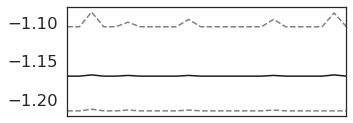

2016-03-12 00:00:00 0.6221024258760108 5.4142707205686774e-39


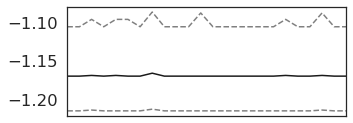

2016-03-10 00:00:00 0.6201465201465202 1.0151352515537761e-38


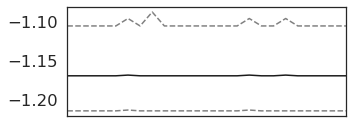

2016-04-10 00:00:00 0.6195970695970696 1.210486670024881e-38


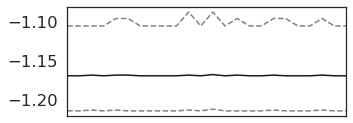

2016-02-07 00:00:00 0.6183150183150183 1.8234165303260743e-38


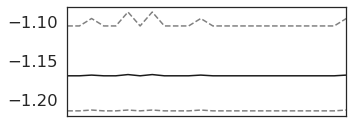

2016-03-03 00:00:00 0.6181318681318682 1.9331048070351587e-38


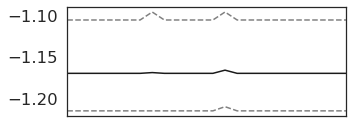

2016-03-14 00:00:00 0.6172161172161172 2.5877461569398673e-38


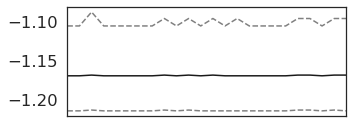

2016-04-05 00:00:00 0.6168498168498169 2.9073927937413467e-38


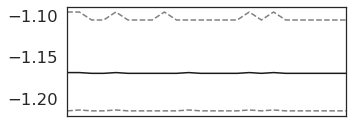

2016-03-13 00:00:00 0.6152014652014652 4.903739742112595e-38


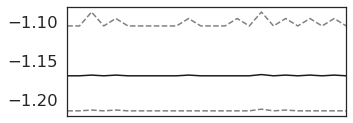

2016-03-07 00:00:00 0.6144688644688645 6.181800417048497e-38


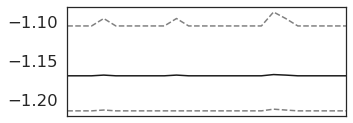

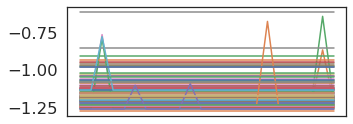

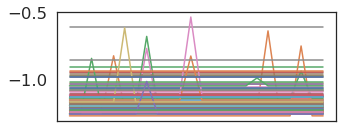

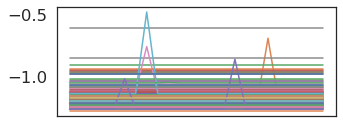

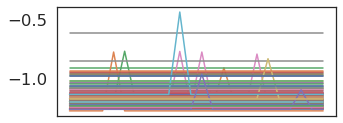

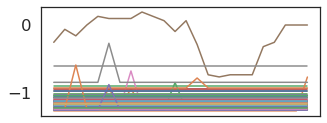

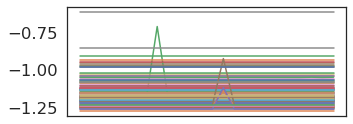

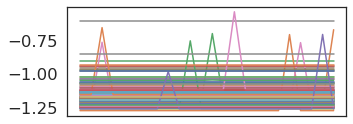

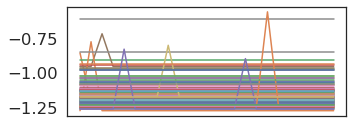

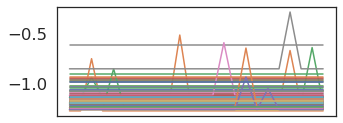

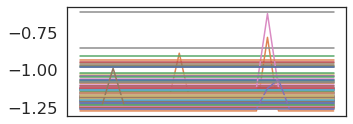

In [6]:
aldi.get_motifs(10)

# All sites with all meters

In [ ]:
# global variables
glb_start_time = time.time()
pvalue = 0.01

# dictionary for the entire dataset
discords = {}
p_nr = {}
aldi_dict = {}

for site in site_id_list:
    # first level is for each site
    discords[site] = {}
    p_nr[site] = {}
    aldi_dict[site] = {}
    
    print(f'For site {site}:')
    
    # DEBUG: only electricity:
#     meter_e = [0]
    for meter_type in meter.keys(): # second level is for each meter type
#     for meter_type in meter_e: # second level is for each meter type
        
        df_site = df_train_sites[(df_train_sites['site_id'] == site)]
        if meter_type not in df_site['meter'].unique():
            print(f'Meter {meter[meter_type]} not available on this site')
            continue

        print(f'For meter {meter[meter_type]}:')
        
        df_site_meter = df_site[df_site['meter'] == meter_type]

        # from the rank-1 solution:
        # https://github.com/buds-lab/ashrae-great-energy-predictor-3-solution-analysis/blob/master/solutions/rank-1/scripts/02_preprocess_data.py
        if site == 0 and meter_type == 0:
            print(f'Updating values for site {site}')
            df_site_meter.meter_reading *= 0.2931
        
        # reshape dataframe for calculations
        all_dfs = []
        for building in df_site_meter.building_id.unique():
            curr_building = df_site_meter[df_site_meter['building_id'] == building]            
            curr_building = curr_building.set_index('timestamp')
            curr_building = curr_building.drop(['building_id', 'meter', 'site_id'], axis=1)
            curr_building = curr_building.rename(columns={'meter_reading': building})#.reset_index(drop=True)
            all_dfs.append(curr_building)

        df_bldgs = pd.concat(all_dfs, axis=1, ignore_index=False)
        
        # compute matrix-profile
        aldi = ALDI(df_bldgs, 
                    building_metadata, 
                    m=24, 
                    col_id='building_id',
                    site_id=site, 
                    meter_id=meter_type)
#         aldi.all_plots_mp()
#         curr_discords, curr_discords_q = aldi.get_discords(pvalue)
#         aldi.all_plots_ks()
#         curr_p_nr = aldi.get_rejected_days()
        
#         discords[site][meter_type] = curr_discords
#         p_nr[site][meter_type] = curr_p_nr
#         aldi_dict[site][meter_type] = aldi
        
        
# will take around 37min
print("--- total: %s seconds ---" % (time.time() - glb_start_time))

# save the files to pickle
save_variable('discords_kaggle', discords)
save_variable('p_nr_kaggle', p_nr)
save_variable('aldi_kaggle', aldi_dict)


# Removing zero-counts before applying ALDI

## Load data

In [2]:
myDataImport = DataImportAshrae()

site_list = [0]
meter_list = [0]

df_site_meter = myDataImport.getMeterData(meter_list, site_list)
df_metadata = myDataImport.getMetaData()
df_timestamps = myDataImport.getTimestamps()
df_true_labels = myDataImport.getLabelData(meter_list, site_list)

df_site_meter.head()

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,29,48
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## ALDI (removing zero counts)

In [3]:
site_id = 0 # should natch the site_list above
meter_type = 0 # should natch the site_list above
p_value = 0.005

# replace 0 with nan
df_site_meter = df_site_meter.replace(0, np.nan)

glb_start_time = time.time()
aldi = ALDI(df_site_meter,
            df_metadata,
            m=24,
            col_id='building_id',
            site_id=site_id, 
            meter_id=meter_type,
            verbose=True,
            gpu=True)

# should take around 3 minutes
print("--- total: %s seconds ---" % (time.time() - glb_start_time))


Using GPU
Midnight MP values:
                0        1       2        3        4        5        6    \
timestamp                                                                  
2016-01-01      NaN      NaN     NaN      NaN      NaN      NaN      NaN   
2016-01-02      NaN      NaN     NaN      NaN      NaN      NaN      NaN   
2016-01-03      NaN      NaN     NaN      NaN      NaN      NaN      NaN   
2016-01-04      NaN      NaN     NaN      NaN      NaN      NaN      NaN   
2016-01-05      NaN      NaN     NaN      NaN      NaN      NaN      NaN   
...             ...      ...     ...      ...      ...      ...      ...   
2016-12-27  227.975  91.1900  4.9144  461.752  1410.85  14.3338  165.862   
2016-12-28  238.214  99.6538  5.7335  130.710  1153.53  25.9373  142.109   
2016-12-29  218.419  94.1933  5.7335  144.020  1124.18  14.3338  138.833   
2016-12-30  221.832  57.0620  5.3240  138.901  1125.54  10.5797  152.347   
2016-12-31  248.452  87.6407  5.3240  196.577  1127.59   9

In [4]:
discord_sort, discord_q = aldi.get_discords(p_value)
print('%s discord days detected' % discord_sort.shape[0])

225 discord days detected


In [ ]:
df_pred_labels = pd.DataFrame(index = df_timestamps.timestamp)
df_pred_labels['day'] = df_pred_labels.index.date
discord_sort.index = discord_sort.index.date
df_pred_labels = df_pred_labels.join(discord_sort.det, on='day', how='left')

In [ ]:
discord_sort.shape[0] == (df_pred_labels.det.sum()/24)
df_pred_labels.det = df_pred_labels.det.fillna(0)
df_pred_labels.det = df_pred_labels.det.astype('int8')
df_pred_labels = df_pred_labels.drop(['day'], axis=1)

In [ ]:
# hand waving specialization (*caution*) of discords from ALDI
for col in df_true_labels:
    df_pred_labels[col] = df_pred_labels['det']

df_pred_labels = df_pred_labels.drop(['det'],axis=1)

In [ ]:
# ground truth outliers (rank1)
# https://github.com/buds-lab/ashrae-great-energy-predictor-3-solution-analysis/blob/master/solutions/rank-2/code/lgb.ipynb

# main outlier technique: count zeros, visually go through all buildings yearly plots to find the dates without data (rank2 and rank3)
# https://www.kaggle.com/ganfear/missing-data-and-zeros-visualized